# Machine Learning Project Report

# 1. Environment & Dateset preparation

## 1.1 Import libraries

In [129]:
import numpy as np
import pandas as pd
import dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from itables import show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [130]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip -qq -o "pima-indians-diabetes-database.zip" -d "dataset"
!echo "Unzip completed"

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
pima-indians-diabetes-database.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzip completed


## 1.2 Dataset Visualization

In [131]:
df = pd.read_csv('dataset/diabetes.csv')
class_names = df['Outcome'].unique()
target = 'Outcome'

In [132]:
# Display the first 5 rows of the dataset
show(df.head())

In [133]:
# Display dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [134]:
with pd.option_context("display.float_format", '{:,.2}'.format):
    # Basic statistics of the dataset
    print(df.describe())

       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count      7.7e+02  7.7e+02        7.7e+02        7.7e+02  7.7e+02 7.7e+02   
mean           3.8  1.2e+02        6.9e+01        2.1e+01    8e+01 3.2e+01   
std            3.4  3.2e+01        1.9e+01        1.6e+01  1.2e+02     7.9   
min            0.0      0.0            0.0            0.0      0.0     0.0   
25%            1.0  9.9e+01        6.2e+01            0.0      0.0 2.7e+01   
50%            3.0  1.2e+02        7.2e+01        2.3e+01    3e+01 3.2e+01   
75%            6.0  1.4e+02          8e+01        3.2e+01  1.3e+02 3.7e+01   
max        1.7e+01    2e+02        1.2e+02        9.9e+01  8.5e+02 6.7e+01   

       DiabetesPedigreeFunction     Age  Outcome  
count                   7.7e+02 7.7e+02  7.7e+02  
mean                       0.47 3.3e+01     0.35  
std                        0.33 1.2e+01     0.48  
min                       0.078 2.1e+01      0.0  
25%                        0.24 2.4e+01   

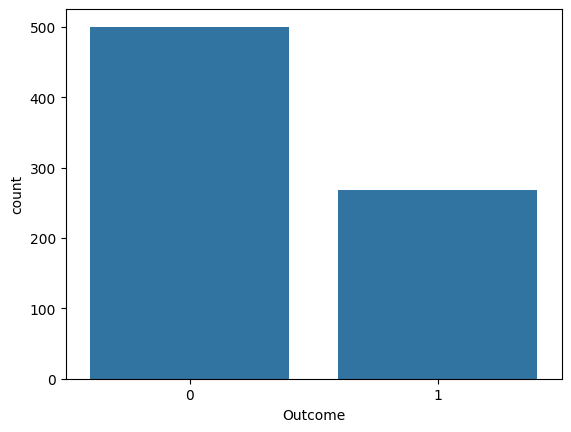

In [135]:
# sns.pairplot(df, hue="Outcome")
# plt.show()

#bar chart by outcome
sns.countplot(data=df, x=target)
plt.show()

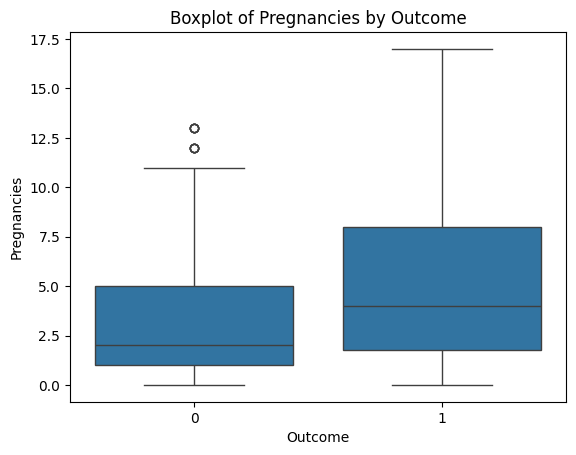

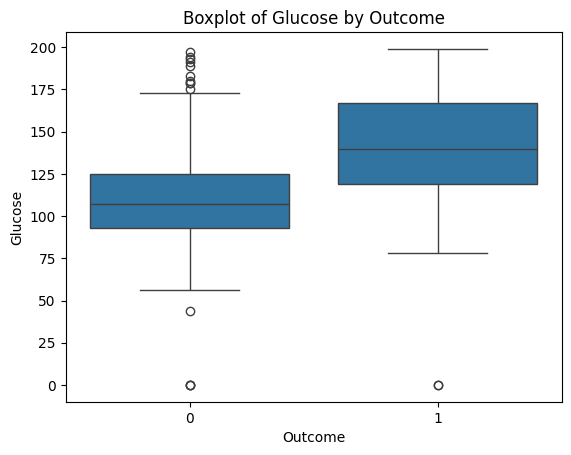

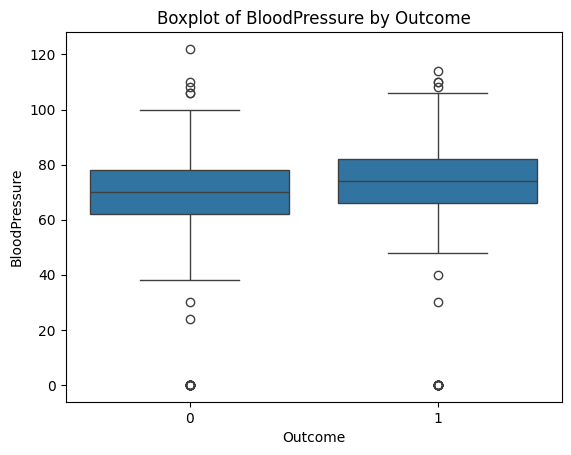

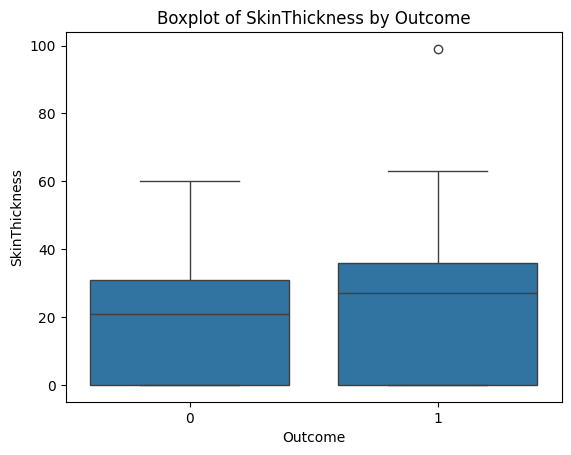

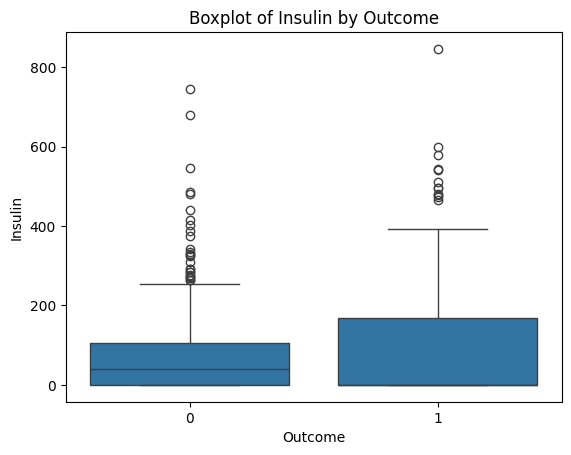

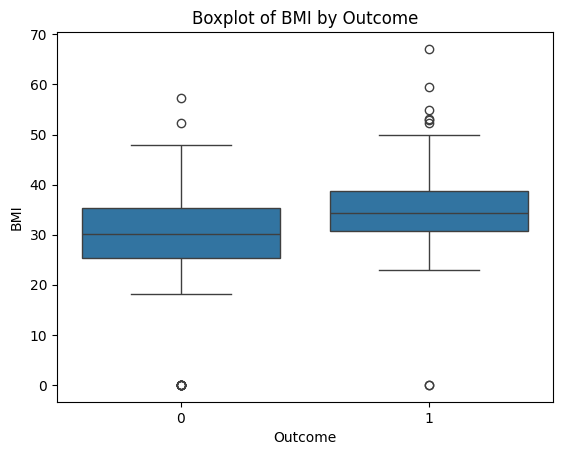

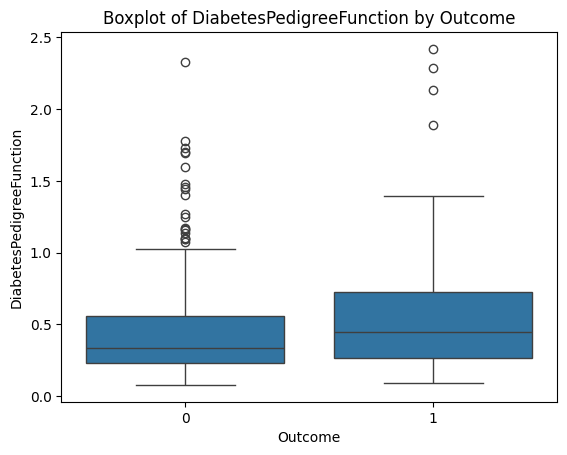

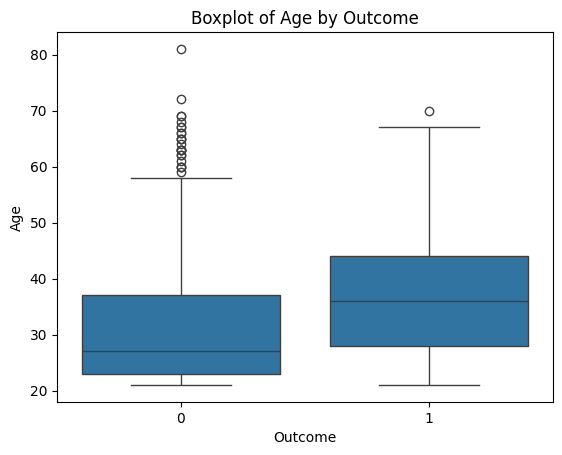

In [136]:
# Creating a boxplot for each numeric feature
features = df.columns.drop([target])
for feature in features:
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Outcome')
    plt.show()

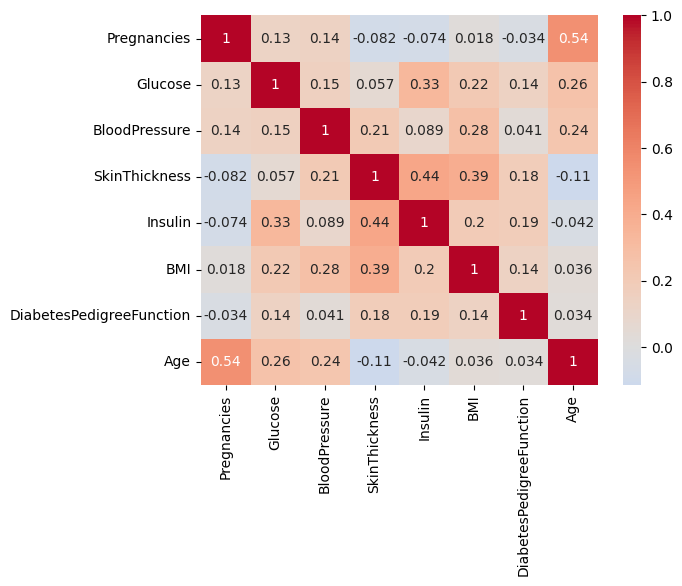

In [137]:
# Calculate correlations
corr = df[features].corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.show()

## 1.3 Dataset loading and pre-processing

In [138]:
def preprocess_dataset(df, target_variable, test_size=0.2, random_state=None):
    """
    General preprocessing pipeline for a dataset to handle missing values, encoding categorical variables, 
    and scaling numerical features.

    Parameters:
    - df: Pandas DataFrame containing the dataset.
    - target_variable: The name of the column to be used as the target variable.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.

    Returns:
    - X_train, X_test, y_train, y_test: preprocessed split data.
    """
    
    # Separate features and target variable
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Identifying numerical and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Creating transformers for numerical and categorical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combining transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Applying the ColumnTransformer to the training and testing sets
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [139]:
X_train, X_test, y_train, y_test = preprocess_dataset(df, target_variable=target, random_state=56)

# 2. Implementation

In [140]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        # Separate the data by class
        self.classes = np.unique(y)
        self.parameters = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0),
                'prior': X_c.shape[0] / X.shape[0]
            }
            
    def calculate_likelihood(self, class_idx, x):
        mean = self.parameters[class_idx]["mean"]
        var = self.parameters[class_idx]["var"]
        numerator = np.exp(-(x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def calculate_posterior(self, x):
        posteriors = []
        
        for c in self.classes:
            prior = np.log(self.parameters[c]["prior"])
            conditional_prob = np.sum(np.log(self.calculate_likelihood(c, x)))
            posteriors.append(prior + conditional_prob)
            
        return self.classes[np.argmax(posteriors)]
    
    def predict(self, X):
        return [self.calculate_posterior(x) for x in X]

# 3. Model Training

In [141]:
nb = GaussianNaiveBayes()
nb.fit(X_train, y_train)

# 4. Testing and evaluation


Classification report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       114
           1       0.58      0.70      0.64        40

    accuracy                           0.79       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.81      0.79      0.80       154



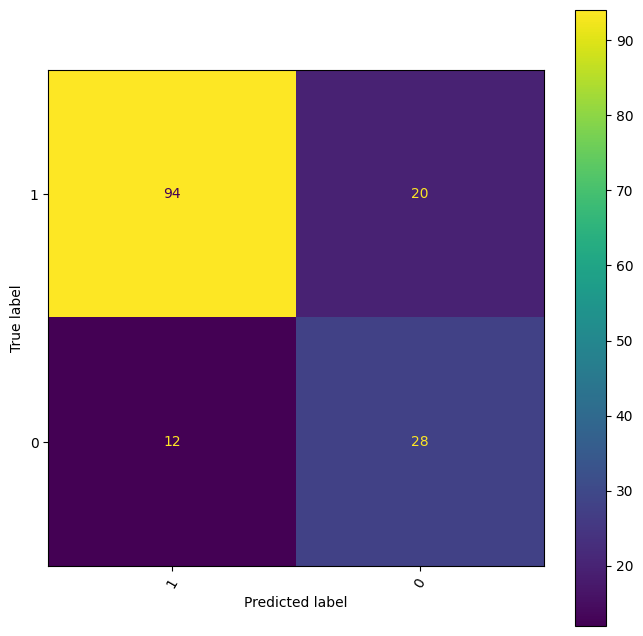

In [142]:
y_pred = nb.predict(X_test)

# Generating the classification report
class_report = classification_report(y_test, y_pred)
print('Classification report:')
print(class_report)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation=60, ax=ax)
plt.show()